<a href="https://colab.research.google.com/github/Orange314159/DataScience/blob/main/MattRobsU5proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# No More Sleep, On to Stock Trading!

# Context

Stock prices are tracked for all openly traded public companies on a stock exchange. These prices have been genearlly been thought of as a way to own a part of the company and be able to benefit from that companies growth. More recently, we have seen the stock market become much more of a tool to predict which companies will "make it big" and we have seen a major explosion in the increase of money in the tech sector.  
  
The main focus of this project will revolve around the quantum computing company Rigetti. Rigetti is a company that was founded in 2013 as a company that produces quantum computers. In 2013, the technology for quantum computing was highly lacking, leading to the minimal uses of quantum computing. Now, while quantum computers are not revolutionary (they still have a ways to go), they are actually able to perform some tasks that classical computers are unable to.  

This progression of Rigetti has led to a major increase in their stock price over time. For the purposes of this project, I will cover how thier stock RGTI relates to their other stock RGTIW. RGTI is the direct stock for Rigetti, and RGTIW is the warrent stock (pretty much a more risky stock that does the same thing). The reason that this context is important is because it justifies why we might expect for these stocks to be directly related.

In [ ]:
%pip install -q preliz
%pip install -q arviz
%pip install -q pymc
%pip install -q polars
%pip install -q matplotlib
%pip install -q numpy
%pip install -q altair
%pip install -q seaborn
%pip install -q pandas

In [2]:
## I will import anything that I could possibly ever want
import preliz as pz
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pymc as pm
import altair as alt
import seaborn as sns
import math
import pandas as pd
import xarray as xr

## Likelihood
I will use the data that I have collected from the daily percent change of stock price of both RGTI and RGTIW.

In [3]:
stockData = pd.read_csv("Data\\Project5DataSet.csv")
stockData

,PCTC(RGTI),PCTC(RGTIW)
0,-1.52493,-3.96104
1,2.89000,5.61000
2,-7.41000,-11.54000
3,2.78000,5.63000
4,-5.00000,-7.76000
...,...,...
210,-20.63000,-12.26000
211,-7.12000,-12.27000
212,5.23000,8.46000
213,0.36939,-3.01000


Now, I can plot this data.

In [ ]:
stockData.plot(x="PCTC(RGTI)", y="PCT(RGTIW)", figsize=(10, 5), kind="scatter")

Well look at that. We can see that this plot does in fact look linear. This means that we do think we can find some linear relation between these two percent changes.

In [ ]:
with pm.Model() as model_stock:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=10)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", α + β * stockData["PCTC(RGTI)"])

    #prior for the standard deviation of our likelihood
    #Cauchy is a T dist with nu = 1
    σ = pm.HalfCauchy("σ", 10)

    #likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=stockData["PCTC(RGTIW)"])

    #inference data object
    idata_stock = pm.sample()

We were then able to create the above model that follows the linear regression that we think we see. From this I can now plot ther posteriors that we generated for alpha, beta and sigma that will influence the way our linear model works.

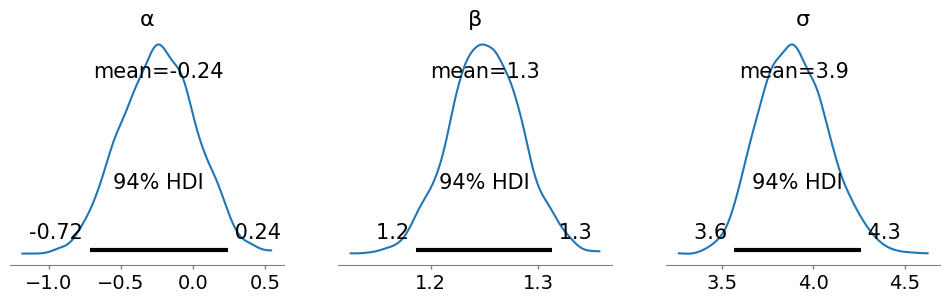

In [9]:
az.plot_posterior(idata_stock, var_names=["~μ"], figsize=(12, 3));

Text(0, 0.5, 'PCTC(RGTIW)')

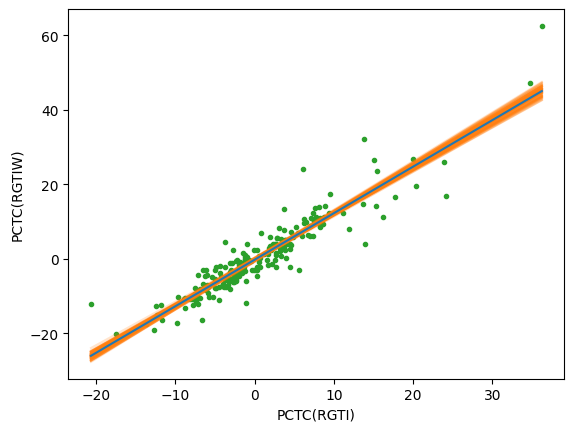

In [10]:
#grabs 100 posterior samples
posterior = az.extract(idata_stock, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(stockData["PCTC(RGTI)"].min(), stockData["PCTC(RGTI)"].max(), 50),
    dims="plot_id"
)

# this creates the expected line, the path we predict temperature and
#rented bike count deviates from
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

#These are a 50 lines that our model came up with
lines = posterior["α"] + posterior["β"] * x_plot

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(stockData["PCTC(RGTI)"], stockData["PCTC(RGTIW)"], "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("PCTC(RGTI)")
ax.set_ylabel("PCTC(RGTIW)")

In [ ]:
pm.sample_posterior_predictive(idata_stock, model=model_stock,  extend_inferencedata=True)

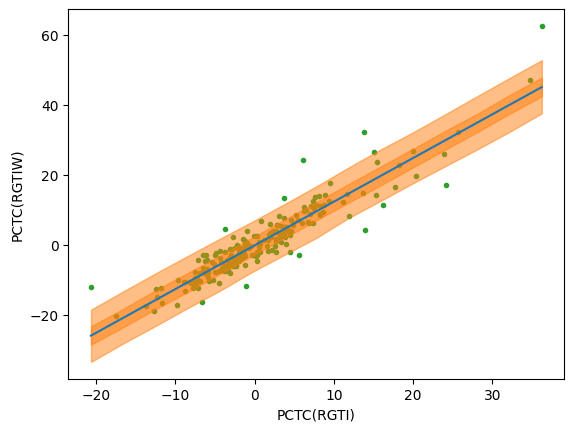

In [12]:
from scipy.interpolate import PchipInterpolator

#grabs the expected line, or line of best fit formula
mean_line = idata_stock.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
pctrgti = np.random.normal(stockData["PCTC(RGTI)"].values, 0.01)
idx = np.argsort(pctrgti)
x = np.linspace(pctrgti.min(), pctrgti.max(), 15)

#grabs the 94% HDI and 50% HDI
y_pred_q = idata_stock.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
#sets up the HDIs for graphing
y_hat_bounds = iter(
    [
        PchipInterpolator(pctrgti[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(stockData["PCTC(RGTI)"], stockData["PCTC(RGTIW)"], "C2.", zorder=-3)
ax.plot(stockData["PCTC(RGTI)"][idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("PCTC(RGTI)")
ax.set_ylabel("PCTC(RGTIW)");

Perfect, we can see the linear regression that pymc found and it looks amazing. This regression includes nearly all of the points and there is no clear trend that we could be missing so we know a linear plot is the best option.  
  
Now all that is left is looking at how well our ppc will follow the observed trend.

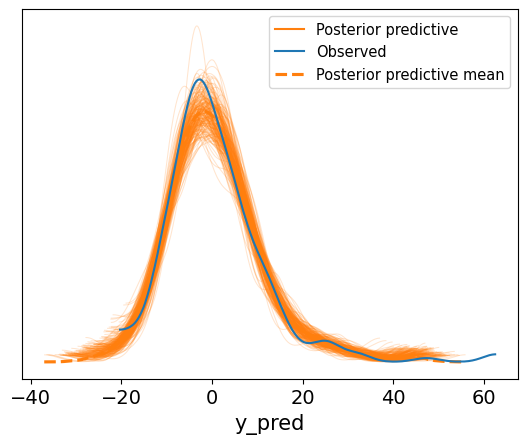

In [13]:
az.plot_ppc(idata_stock, num_pp_samples=200, colors=["C1", "C0", "C1"]);

## Conclusion

And it is clear that this is a really good plot. It even follows the squiggles that we see around 30-50. But was this result unexpected?  
  
No. If we look more closely into what a warrent stock is, it is the right to purchase a share of the parent stock, so it would make sense that if the parent stock was going up, the warent stock would follow it because more people would want to have the right to purchase the parent stock.